# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Read the data first

In [4]:
from nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution()

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']

## Analysis 1: How many commits containing safetensors files were made by HF's conversion tool?

HuggingFace has a [tool](https://huggingface.co/spaces/safetensors/convert) that converts models to safetensors.
How many commits were made by the tool and how many were made by developers themselves?
Hugging Face bot's source code: https://github.com/huggingface/safetensors/commits/main/bindings/python/convert.py

In [9]:
from nb_utils import RESULTS_DIR
from nb_utils import get_commit_log_stats
import pandas as pd

stats = get_commit_log_stats()

# check if the message contains the auto-converter message
bot_message = "Adding `safetensors` variant of this model"
df_safetensors_not_by_tool = df_safetensors[~df_safetensors['message'].str.contains(bot_message)]
df_safetensors_by_tool = df_safetensors[df_safetensors['message'].str.contains(bot_message)]

# compute number of unique repo_url and commit_hash combination in df
num_commits = len(df[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits = len(df_safetensors[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits_by_bot = len(df_safetensors_by_tool[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits_not_by_bot = len(df_safetensors_not_by_tool[['repo_url', 'commit_hash']].drop_duplicates())

# Compute some more statistics to be saved
stats.loc['# commits touching safetensor files'] = num_safetensors_commits
stats.loc['# commits made by the converter'] = num_safetensors_commits_by_bot
stats.loc['% commits made by the converter'] = num_safetensors_commits_by_bot / num_safetensors_commits * 100
stats.loc['# commits made by developers'] = num_safetensors_commits_not_by_bot
stats.loc['% commits made by developers'] = num_safetensors_commits_not_by_bot / num_safetensors_commits * 100
stats.loc['how many days until first safetensors is adopted'] = df_safetensors['elapsed_days'].min()
stats.loc['date with max number of adoptions'] = str(df_safetensors[df_safetensors['elapsed_days'] == df_safetensors['elapsed_days'].mode().values[0]].iloc[0]['date']).split(" ")[0]
stats.to_csv(RESULTS_DIR / 'rq1_dataset_stats.csv',  header=False)

# save the dataframes
df_safetensors_not_by_tool.to_csv(RESULTS_DIR / 'safetensors_commits_not_by_tool.csv', index=False)
df_safetensors_by_tool.to_csv(RESULTS_DIR / 'safetensors_commits_by_tool.csv', index=False)
stats

# commits in all logs (total)                                  17773.0
# commits touching at least one serialized model                4889.0
# commits containing at least one model file in its tree        4872.0
# commits not containing at least one model file                  17.0
# repos                                                         1032.0
# commits touching safetensor files                              505.0
# commits made by the converter                                  400.0
% commits made by the converter                              79.207921
# commits made by developers                                     105.0
% commits made by developers                                 20.792079
how many days until first safetensors is adopted                   6.0
date with max number of adoptions                           2024-03-27
dtype: object

## Analysis 2: Number of elapsed days since the release of safetensors

This script checks how long it took safetensors to first appear in each analyzed repository.

In [4]:
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min().sort_values()
df_safetensors_first_appearance.head(5)

repo_url
openai-community/gpt2              6
FacebookAI/roberta-large           6
FacebookAI/roberta-base            6
distilbert/distilgpt2             52
google-bert/bert-large-uncased    52
Name: elapsed_days, dtype: int64

## Analysis 3: Plot the number of adoptions per elapsed days

Since the first safetensors release, shows the number of model files using safetensors per elapsed days.

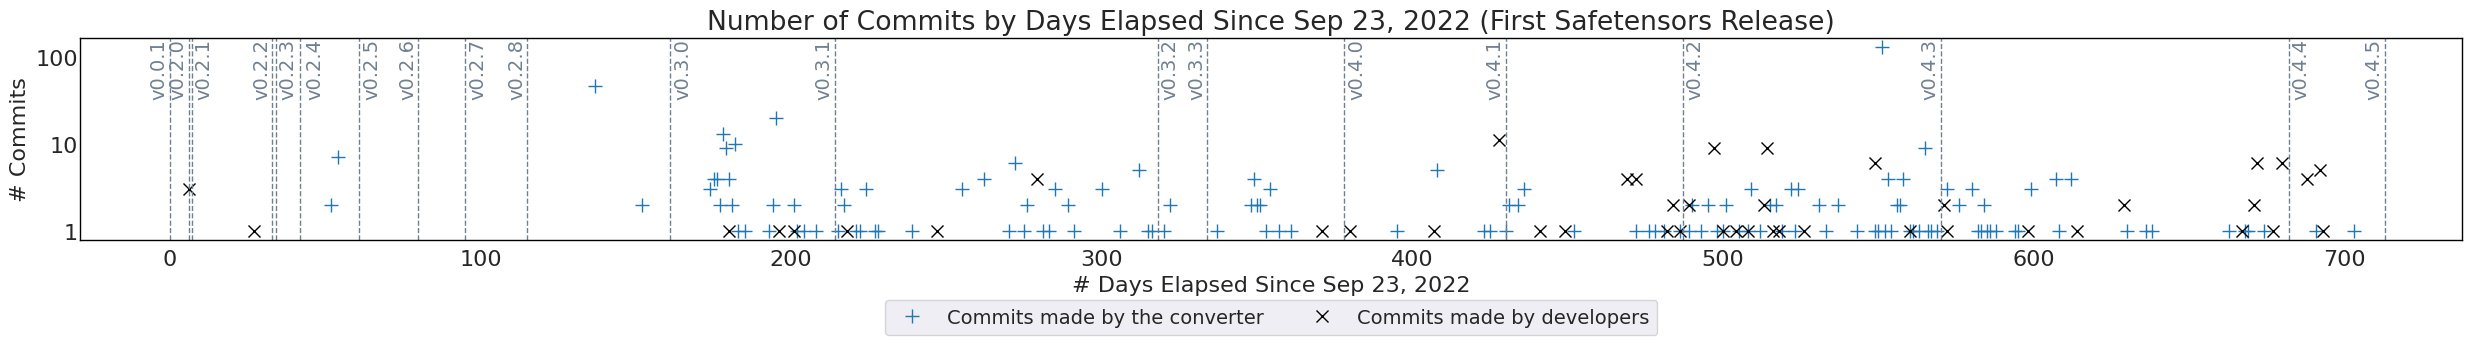

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Group by elapsed days to count files modified on each date
all_commits = df_safetensors['elapsed_days'].value_counts().sort_index()
commits_not_by_bot = df_safetensors_not_by_tool['elapsed_days'].value_counts().sort_index()
commits_by_bot = df_safetensors_by_tool['elapsed_days'].value_counts().sort_index()

# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans' 
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed
# specify default font size
plt.rcParams.update({'font.size': 16})

# Plotting
plt.figure(figsize=(25,4), facecolor="white")  # Set figure background to white
ax = plt.gca()  # Get the current axis
ax.set_facecolor("white")  # Set axis background to white

# Ensure the visibility of x-axis and y-axis lines (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.0)


plt.plot(commits_by_bot.index, commits_by_bot.values, 
         marker='+', linestyle='None', markersize=10,  label="Commits made by SFConvert bot")
plt.plot(commits_not_by_bot.index, commits_not_by_bot.values, 
         marker='x', linestyle='None', color='black', markersize=9, label="Commits not made by SFConvert bot")

plt.xlabel("# Days Elapsed Since Sep 23, 2022")
plt.ylabel("# Commits")
plt.title("Number of Commits by Days Elapsed Since Sep 23, 2022 (First Safetensors Release)")
plt.yscale('log')
plt.yticks([1, 10, 100], ['1', '10', '100'])
# plt.xticks(fontsize=14)
plt.grid(True)
plt.legend(
    ('Commits made by the converter','Commits made by developers'),
    loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=14)
plt.tight_layout()


df_releases  = get_safetensors_releases()

#  add vertical lines for each release date with labels
color, i, x_coordinates = 'slategray', 0, [1, -6.5]

for day, label in df_releases[['date', 'tag']].values:
    i = (i + 1) % 2
    diff = (day - SAFETENSORS_RELEASE_DATE).days
    plt.axvline(x=diff,color=color, linestyle='--', linewidth=1)
    x_offset = 1.5 if label == 'v0.2.4' else  x_coordinates[i]
    plt.text(diff + x_offset, plt.ylim()[1] * 0.99, label, color=color, rotation=90, verticalalignment='top', fontdict={'size':14})
    if label == 'v0.0.1': i = 2


# Save the plot as a PDF file
plt.savefig(RESULTS_DIR /'RQ1CommitsDistribution.pdf', format="pdf", bbox_inches="tight")

plt.show()

## Analysis 4: Number of adoptions as heatmap

NameError: name 'calendar' is not defined

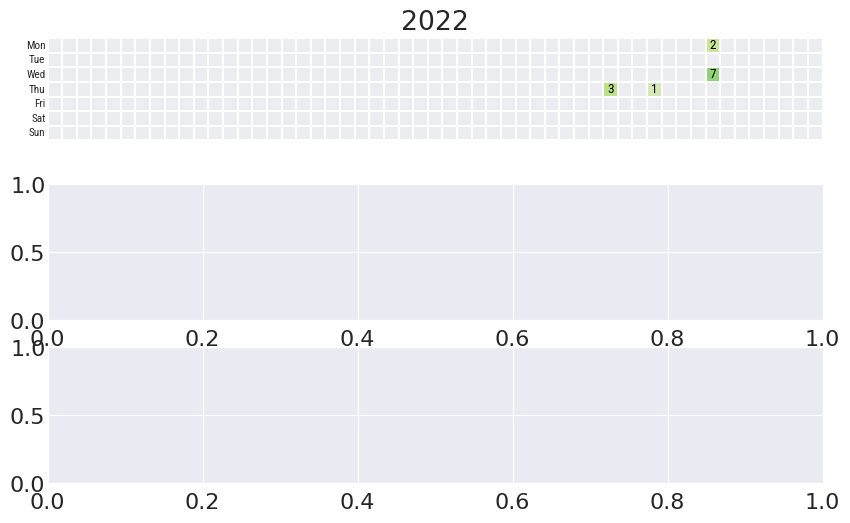

In [11]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pathlib import Path
from matplotlib.patches import Rectangle
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings are very unnecessary. They can only do harm  🎶
# Enjoy the silence :)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  


# Create a font property with Noto Emoji and Roboto Condensed fonts
emoji_font = FontProperties(fname=Path('../../assets/NotoEmoji-Regular.ttf'))
color_emoji_font = FontProperties(fname=Path('../../assets/NotoColorEmoji-Regular.ttf'))
roboto_condensed_font = FontProperties(fname=Path('../../assets/RobotoCondensed-Regular.ttf'))
                            
# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans' 
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed


# group by timestamp, and ignore the times, just group based on the date
commits_by_date = df_safetensors.groupby(df_safetensors['date'].dt.floor('D')).size().sort_index()

# add all dates from SAFE TENSORS RELEASE DATE to today
for i in range(0, (pd.Timestamp.today() - SAFETENSORS_RELEASE_DATE).days):
    date = SAFETENSORS_RELEASE_DATE + pd.Timedelta(days=i)
    if date not in commits_by_date.index:
        commits_by_date.loc[date] = 0
commits_by_date = commits_by_date.sort_index()
# name the count as 'count'
commits_by_date.name = 'count'

# Ensure 'files_modified_by_date' has datetime as the index if not already
commits_by_date.index = pd.to_datetime(commits_by_date.index)

# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()

# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_annotations(year, ax):
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts for annotation
    year_data = year_data.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)
    year_data_original = year_data_original.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix = np.zeros((7, 53))
    year_matrix_original = np.zeros((7, 53))

    for i, (date, value) in enumerate(year_data.items()):
        week = date.isocalendar().week - 1
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=9.5, color='black' if year_matrix_original[row, col] < vmax else 'white', fontproperties=roboto_condensed_font)
                

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    # # set font family for the labels
    for label in ax.get_yticklabels():
        label.set_fontproperties(roboto_condensed_font)
        #change font size
        label.set_fontsize(8)
        # make label as close as possible to chart
        label.set_verticalalignment('center')
        # decrease padding
        # label.set_pad(0)
    # 
    # Adjust the month labels along the x-axis
    month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
    
    if year == 2022:
        # Define the day and week position to highlight
        highlight_day = 4  # Example: 2 for Wednesday
        highlight_week = 37  # Example week to highlight
        # Add a red patch to highlight the selected square
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        # Add a text annotation to highlight the selected square
        ax.text(highlight_week + 3, highlight_day + 2, "Safetensor's\nfirst release", ha='center', va='center', color="black", fontsize=10, weight='bold')       
        # Add a vertical line to highlight the selected week
        ax.text(highlight_week + 0.5, highlight_day + 0.5, "🚩", fontproperties=emoji_font,
                        ha='center', va='center', fontsize=10, color='black' )
         

# Plot horizontal heatmaps with annotations for non-zero values
fig, axes = plt.subplots(len(years), 1, figsize=(10, 6))

for i, year in enumerate(years):
    plot_year_heatmap_with_annotations(year, axes[i])

plt.tight_layout()
plt.savefig(Path('../../results/RQ1Heatmap.pdf'), bbox_inches='tight', format='pdf')
plt.show()


## Analysis 5: Horizontal Calendar HeatMap


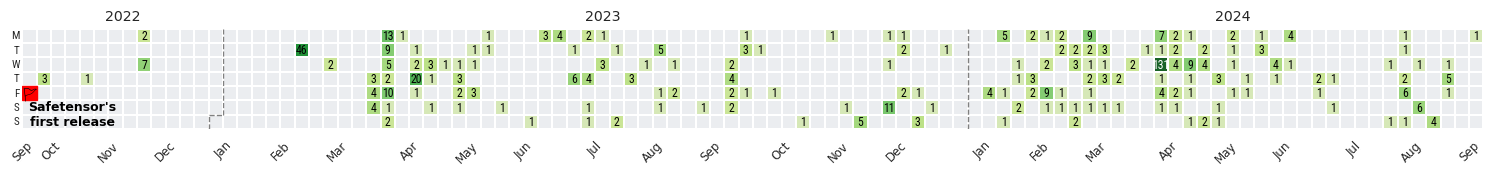

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import numpy as np

# leave me alone, FFS.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore UserWarnings from Matplotlib



# Create a font property with Noto Emoji and Roboto Condensed fonts
emoji_font = FontProperties(fname=Path('../../assets/NotoEmoji-Regular.ttf'))
color_emoji_font = FontProperties(fname=Path('../../assets/NotoColorEmoji-Regular.ttf'))
roboto_condensed_font = FontProperties(fname=Path('../../assets/RobotoCondensed-Regular.ttf'))
                            
# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans' 
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -1.5  # Decrease this value as needed
# set default font size
plt.rcParams.update({'font.size': 8.5})



# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()
vmin = commits_by_date.min()
# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_custom_start_fixed(year, ax, start_month=None, end_month=None):
    # Define start date for each year
    if year == 2022 and start_month is not None:
        start_date = f"{year}-{start_month:02d}-19"
    else:
        start_date = f"{year}-01-01"
    if year == 2024:
        # end_date = f"{year}-{end_month:02d}-30"
        end_date = f"{year}-08-31"
    else:
        if year == 2022:
            end_date = f"{year}-12-25"
        else:
            end_date = f"{year}-12-31"

    # Create a DataFrame with dates for the specified range
    year_data = log_commits_by_date[start_date:end_date]
    year_data_original = commits_by_date[start_date:end_date]  # Original counts for annotation

    # Calculate the number of weeks from the adjusted start date to the end of the year
    weeks_in_range = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days // 7 + 1
    year_matrix = np.zeros((7, weeks_in_range))
    year_matrix_original = np.zeros((7, weeks_in_range))

    for i, (date, value) in enumerate(year_data.items()):
        week = (date - pd.Timestamp(start_date)).days // 7  # Adjust week index from start_date
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] )
    
    # Add annotations for non-zero values
    for row in range(7):
        for col in range(weeks_in_range):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=8.5, color='black' if year_matrix_original[row, col] < vmax else 'white', fontproperties=roboto_condensed_font)

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    # ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] if year == 2022 else [])
    ax.set_yticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'] if year == 2022 else [])
    
    # set font family for the labels
    for label in ax.get_yticklabels():
        label.set_fontproperties(roboto_condensed_font)
        label.set_fontsize(8)
        label.set_verticalalignment('center')
        
    # Adjust the month labels along the x-axis for the selected range
    if year == 2022:
        month_ticks = [0, 2, 6, 10]  # Adjusted ticks for Sep to Dec
        ax.set_xticks(month_ticks)
        ax.set_xticklabels(['Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    elif year == 2024:
        month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34]
        ax.set_xticks(month_ticks)
        ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 10)], rotation=45)
    else:
        month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
        ax.set_xticks(month_ticks)
        ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
    # Add a safetensors pin
    if year == 2022:
        # Define the day and week position to highlight
        highlight_day = 4  # Friday
        highlight_week = 0  # Week to highlight
        # Add a red patch to highlight the selected square
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        # Add a text annotation to highlight the selected square
        ax.text(highlight_week + 3.5, highlight_day + 2, "Safetensor's\nfirst release", 
                ha='center', va='center', color="black", fontsize=9, weight='bold')       
        # Add a vertical line to highlight the selected week
        ax.text(highlight_week + 0.5, highlight_day + 0.5, "🚩", fontproperties=emoji_font,
                        ha='center', va='center', fontsize=9.5, color='black' )
    # Draw a gray dashed vertical line at the end of each year
    if year == 2023:  # Only add a line if it's not the last year
        ax.axvline(x=52, color="gray", linestyle="--", linewidth=1)  # Adjust x to align with end of year
        ax.axvline(x=0, color="gray", linestyle="--", linewidth=1, ymin=0.14, ymax=1)
    if year == 2022:
        ax.axvline(x=13, color="gray", linestyle="--", linewidth=1, ymin=0, ymax=0.14)
        # Add a horizontal dashed line at the specified y position (e.g., between Friday and Saturday)
        ax.hlines(y=6, xmin=13, xmax=14, color="gray", linestyle="--", linewidth=1)  # Adjust `y` as needed

# Plot horizontal heatmaps, starting 2022 from September
fig, axes = plt.subplots(1, len(years), figsize=(15, 6), gridspec_kw={'width_ratios': [14, 53, 35],'wspace': 0})

for i, year in enumerate(years):
    if year == 2022:
        plot_year_heatmap_with_custom_start_fixed(year, axes[i], start_month=9)
    elif year == 2024:
        plot_year_heatmap_with_custom_start_fixed(year, axes[i], end_month=9)
    else:
        plot_year_heatmap_with_custom_start_fixed(year, axes[i])

plt.tight_layout()


# save as PDF on results folder
plt.savefig(RESULTS_DIR / 'RQ1HeatmapHorizontal.pdf', bbox_inches='tight', format='pdf')

plt.show()

## Analysis 6: After using safetensors are developers deleting the old model files?

In [56]:
# read the file ../../data/huggingface_sort_by_createdAt_top996939_commits_0_1035.csv
df_commits = pd.read_csv(Path('../../data/huggingface_sort_by_createdAt_top996939_commits_0_1035.csv'))
# find the latest commit  for each repo
# sort frame by repo and date
df_commits['date'] = pd.to_datetime(df_commits['date'])
df_commits = df_commits.sort_values(by=['repo_url', 'date'], ascending=[True, False])
# get the last commit for each repo
df_latest_commits = df_commits.groupby('repo_url').first()
df_latest_commits.reset_index(inplace=True)

# only keep in df_latest_commits those whose repo_url are in df_safetensors_by_bot
df_latest_commits = df_latest_commits[df_latest_commits['repo_url'].isin(df_safetensors_by_tool['repo_url'])]

df_repos_with_old_files = pd.DataFrame(columns=df_latest_commits.columns)
# find the files in the last commit and whether they still contain the old model files
for index, row in df_latest_commits.iterrows():
    files = row['all_files_in_tree'].split(";")
    # print(files)
    if 'pytorch_model.bin' in files:
        # add to df_repos_with_old_files
        df_repos_with_old_files = pd.concat([df_repos_with_old_files, row.to_frame().T])
df_repos_with_old_files
# print(len(df_latest_commits))
# print(len(df_safetensors['repo_url'].unique()))
stats.loc['# repos with old `pytorch_model.bin` file after conversion'] = len(df_repos_with_old_files)
stats.loc['% repos with old files'] = len(df_repos_with_old_files) / len(df_safetensors_by_tool['repo_url'].unique()) * 100
stats.to_csv(RESULTS_DIR / 'rq1_dataset_stats.csv',  mode='a', header=False)